In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/DRL. policy iteration')

Mounted at /content/drive


In [2]:
from Frozen_Lake import FrozenLakeEnv

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Value Iteration


In [22]:
env = FrozenLakeEnv()

#Algorithm

If reward don not depend on s' - next state:
$$
q(s, a) = R(s, a) + \gamma \sum_{s'}P(s'|s, a) v(s')
$$
If reward depends on s': (our case)
$$
q(s, a) = \sum_{s'} P(s'|s, a) \Big( R(s, a, s') + \gamma  v(s')\Big)
$$

If reward do not depends on s' - it is special case of the dependece on s'

$$
q(s, a) = \sum_{s'} P(s'|s, a) \Big( R(s, a) + \gamma  v(s')\Big) = R(s, a) \sum_{s'} P(s'|s,a) + \gamma \sum_{s'}P(s'|s, a) v(s') = R(s, a) + \gamma \sum_{s'}P(s'|s, a) v(s')
$$

In [23]:
counter = 0 #count interactions with the area

In [24]:
def get_q_values(v_values, gamma):
  global counter
  counter += 1
  q_values = {}
  for state in env.get_all_states():
    q_values[state] = {}
    for action in env.get_possible_actions(state):
      q_values[state][action] = 0
      for next_state in env.get_next_states(state, action):
        q_values[state][action] += env.get_transition_prob(state, action, next_state) * env.get_reward(state, action, next_state)
        q_values[state][action] += gamma * env.get_transition_prob(state, action, next_state) * v_values[next_state]

  return q_values

In [25]:
def init_policy():
  policy = {}
  for state in env.get_all_states():
    policy[state] = {}
    for action in env.get_possible_actions(state):
      policy[state][action] = 1 / len(env.get_possible_actions(state)) #uniform filling

  return policy

In [26]:
def init_v_values():
  v_values = {}
  for state in env.get_all_states():
    v_values[state] = 0
  return v_values

## Value iteration

Let $v^0(s), s\in S$ and $K \in \mathbb{N}$.

For each $k \in \overline{0, K},$ do:

$$v^{k+1}(s) = \underset{a \in A}{max} (R(s, a) + \gamma \sum_{s'} P(s'|s, a) v^k(s'))$$

If reward depends on s': (our case)
$$
v^{k+1}(s)  = \underset{a \in A}{max} \sum_{s'} P(s'|s, a) \Big( R(s, a, s') + \gamma  v^k(s')\Big)
$$
Then we have theorem:

$$
v^k \rightarrow v_*, k \rightarrow \infty \text{: convergence rate } O(mn^2)
$$
Then we can obtain q-values as in policy iteration case:

$$
v_*(s) = \underset{a \in A}{max} q_*(s, a)
$$

$$
q_*(s, a) = R(s, a) + \gamma \sum_{s'}P(s'|s, a) v_*(s')
$$

In [27]:
def value_evaluation_step(v_values, policy, gamma):

    v_values_new = {}
    for state in env.get_all_states():
        v_values_new[state] = 0
    for state in env.get_all_states():
        v_values_new_prob = {}
        for action in env.get_possible_actions(state):
            v_values_new_prob[state] = 0
            for next_state in env.get_next_states(state, action):
                v_values_new_prob[state] += env.get_transition_prob(state, action, next_state) * env.get_reward(state, action, next_state)
                v_values_new_prob[state] += gamma * env.get_transition_prob(state, action, next_state) * v_values[next_state]
            v_values_new[state] = max(v_values_new_prob[state], v_values_new[state])


    return v_values_new

In [28]:
def value_evaluation(policy, gamma, eval_iter_n):
  v_values = init_v_values()
  for _ in range(eval_iter_n):
    v_values = value_evaluation_step(v_values, policy, gamma)
  q_values = get_q_values(v_values, gamma)
  return q_values

Greedy Policy Improvement:


---

$$\pi_*(a|s) = \begin{cases}
  1, & \text{if } a\in argmax_{a' \in A} q_* (s, a') \\    
  0, & \text{otherwise}   
\end{cases}
$$

In [29]:
def policy_improvement(q_values):
  policy = {}
  for state in env.get_all_states():
    policy[state] = {}
    argmax_action = None
    max_q_value = float('-inf')

    for action in env.get_possible_actions(state):
      policy[state][action] = 0

      if q_values[state][action] > max_q_value:
        argmax_action = action
        max_q_value = q_values[state][action]

    policy[state][argmax_action] = 1

  return policy

In [30]:
iter_n = 100
eval_iter_n = 100 #iteration of evaluation stage
gamma = 0.99

policy = init_policy()

for _ in range(iter_n):
  q_values = value_evaluation(policy, gamma, eval_iter_n)
  policy = policy_improvement(q_values)

In [31]:
policy

{(0, 0): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (0, 1): {'left': 0, 'down': 0, 'right': 0, 'up': 1},
 (0, 2): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (0, 3): {'left': 0, 'down': 0, 'right': 0, 'up': 1},
 (1, 0): {'left': 1, 'down': 0, 'right': 0, 'up': 0},
 (1, 1): {None: 1},
 (1, 2): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (1, 3): {None: 1},
 (2, 0): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (2, 1): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (2, 2): {'left': 1, 'down': 0, 'right': 0, 'up': 0},
 (2, 3): {None: 1},
 (3, 0): {None: 1},
 (3, 1): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (3, 2): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (3, 3): {None: 1}}

## Testing

In [32]:
total_rewards = []

for _ in range(500):
  total_reward = 0
  state = env.reset()
  for _ in range(1000):
    action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
    state, reward, done, _ = env.step(action)
    total_reward += reward

    #env.render()
    #time.sleep(0.2)

    if done:
      break

  total_rewards.append(total_reward)

np.mean(total_rewards) #percent of right moves

0.898

In [33]:
policy

{(0, 0): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (0, 1): {'left': 0, 'down': 0, 'right': 0, 'up': 1},
 (0, 2): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (0, 3): {'left': 0, 'down': 0, 'right': 0, 'up': 1},
 (1, 0): {'left': 1, 'down': 0, 'right': 0, 'up': 0},
 (1, 1): {None: 1},
 (1, 2): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (1, 3): {None: 1},
 (2, 0): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (2, 1): {'left': 0, 'down': 1, 'right': 0, 'up': 0},
 (2, 2): {'left': 1, 'down': 0, 'right': 0, 'up': 0},
 (2, 3): {None: 1},
 (3, 0): {None: 1},
 (3, 1): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (3, 2): {'left': 0, 'down': 0, 'right': 1, 'up': 0},
 (3, 3): {None: 1}}

#What's gamma is the best?


In [34]:
iter_n = 1100
eval_iter_n = 10 #iteration of evaluation stage
gamma = 0.99

mean_rewards = []
gammas = []

for gamma in [0.1 * x for x in range(1, 10)]:

    policy = init_policy()

    for _ in range(iter_n):
        q_values = value_evaluation(policy, gamma, eval_iter_n)
        policy = policy_improvement(q_values)

    total_rewards = []

    for _ in range(1000):
        total_reward = 0
        state = env.reset()
        for _ in range(1000):
            action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = env.step(action)
            total_reward += reward

        #env.render()
        #time.sleep(0.2)

            if done:
                break

        total_rewards.append(total_reward)

    mean_rewards.append(np.mean(total_rewards))
    gammas.append(gamma)
    counterx = counter
    counter = 0
    print(f'gamma: {gamma} and mean total rewards: {np.mean(total_rewards)}')
print(f'counter: {counterx}')

gamma: 0.1 and mean total rewards: 0.743
gamma: 0.2 and mean total rewards: 0.771
gamma: 0.30000000000000004 and mean total rewards: 0.739
gamma: 0.4 and mean total rewards: 0.738
gamma: 0.5 and mean total rewards: 0.73
gamma: 0.6000000000000001 and mean total rewards: 0.729
gamma: 0.7000000000000001 and mean total rewards: 0.734
gamma: 0.8 and mean total rewards: 0.731
gamma: 0.9 and mean total rewards: 0.75
counter: 1100


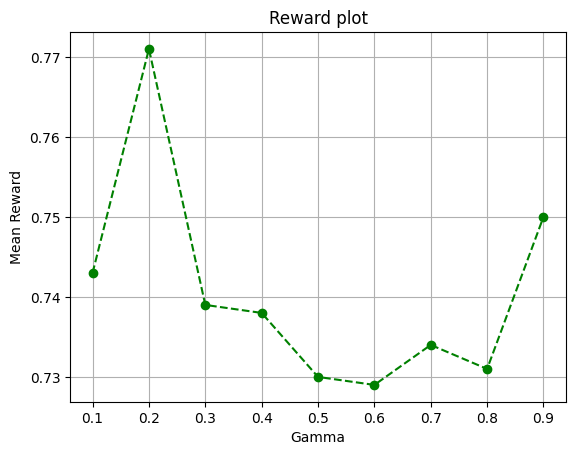

In [35]:
# Create plot
plt.plot(gammas, mean_rewards, color='green', marker='o', linestyle='--')

# Add title and labels
plt.title('Reward plot')
plt.xlabel('Gamma')
plt.ylabel('Mean Reward')

# Add grid
plt.grid(True)

In [36]:
iter_n = 100
eval_iter_n = 100
gamma = 0.99

mean_rewards = []
gammas = []

for gamma in [0.01 * x for x in range(90, 100)]:

    policy = init_policy()

    for _ in range(iter_n):
        q_values = value_evaluation(policy, gamma, eval_iter_n)
        policy = policy_improvement(q_values)

    total_rewards = []

    for _ in range(1000):
        total_reward = 0
        state = env.reset()
        for _ in range(1000):
            action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = env.step(action)
            total_reward += reward

        #env.render()
        #time.sleep(0.2)

            if done:
                break

        total_rewards.append(total_reward)

    mean_rewards.append(np.mean(total_rewards))
    gammas.append(gamma)

    print(f'gamma: {gamma} and mean total rewards: {np.mean(total_rewards)}')

gamma: 0.9 and mean total rewards: 0.742
gamma: 0.91 and mean total rewards: 0.725
gamma: 0.92 and mean total rewards: 0.739
gamma: 0.93 and mean total rewards: 0.726
gamma: 0.9400000000000001 and mean total rewards: 0.738
gamma: 0.9500000000000001 and mean total rewards: 0.723
gamma: 0.96 and mean total rewards: 0.766
gamma: 0.97 and mean total rewards: 0.771
gamma: 0.98 and mean total rewards: 0.759
gamma: 0.99 and mean total rewards: 0.881


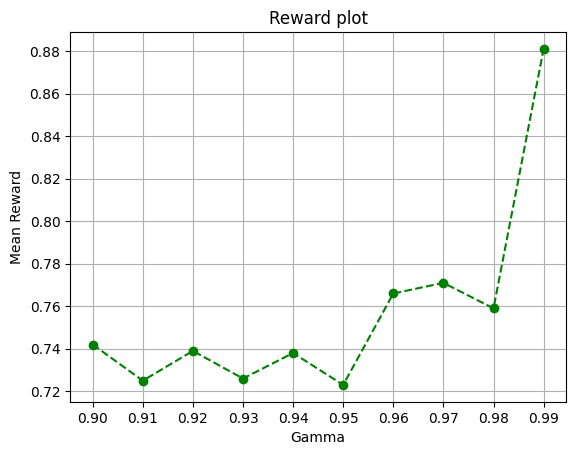

In [37]:
# Create plot
plt.plot(gammas, mean_rewards, color='green', marker='o', linestyle='--')
plt.xticks(np.arange(0.9, 1, 0.01))
# Add title and labels
plt.title('Reward plot')
plt.xlabel('Gamma')
plt.ylabel('Mean Reward')

# Add grid
plt.grid(True)

In [38]:
iter_n = 100
eval_iter_n = 100
gamma = 0.99

mean_rewards = []
gammas = []

for gamma in [0.001 * x for x in range(990, 1000)]:

    policy = init_policy()

    for _ in range(iter_n):
        q_values = value_evaluation(policy, gamma, eval_iter_n)
        policy = policy_improvement(q_values)

    total_rewards = []

    for _ in range(1000):
        total_reward = 0
        state = env.reset()
        for _ in range(1000):
            action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = env.step(action)
            total_reward += reward

        #env.render()
        #time.sleep(0.2)

            if done:
                break

        total_rewards.append(total_reward)

    mean_rewards.append(np.mean(total_rewards))
    gammas.append(gamma)

    print(f'gamma: {gamma} and mean total rewards: {np.mean(total_rewards)}')

gamma: 0.99 and mean total rewards: 0.871
gamma: 0.991 and mean total rewards: 0.856
gamma: 0.992 and mean total rewards: 0.85
gamma: 0.993 and mean total rewards: 0.856
gamma: 0.994 and mean total rewards: 0.846
gamma: 0.995 and mean total rewards: 0.882
gamma: 0.996 and mean total rewards: 0.874
gamma: 0.997 and mean total rewards: 0.853
gamma: 0.998 and mean total rewards: 0.853
gamma: 0.999 and mean total rewards: 0.963


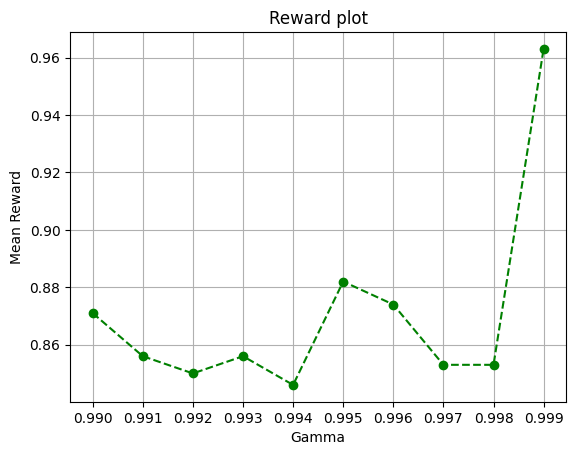

In [39]:
# Create plot
plt.plot(gammas, mean_rewards, color='green', marker='o', linestyle='--')
plt.xticks(np.arange(0.990, 0.999, 0.001))
# Add title and labels
plt.title('Reward plot')
plt.xlabel('Gamma')
plt.ylabel('Mean Reward')

# Add grid
plt.grid(True)

In [40]:
iter_n = 100
eval_iter_n = 100
gamma = 0.99

mean_rewards = []
gammas = []

for gamma in [0.0001 * x for x in range(9990, 10000)]:

    policy = init_policy()

    for _ in range(iter_n):
        q_values = value_evaluation(policy, gamma, eval_iter_n)
        policy = policy_improvement(q_values)

    total_rewards = []

    for _ in range(1000):
        total_reward = 0
        state = env.reset()
        for _ in range(1000):
            action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = env.step(action)
            total_reward += reward

        #env.render()
        #time.sleep(0.2)

            if done:
                break

        total_rewards.append(total_reward)

    mean_rewards.append(np.mean(total_rewards))
    gammas.append(gamma)

    print(f'gamma: {gamma} and mean total rewards: {np.mean(total_rewards)}')

gamma: 0.999 and mean total rewards: 0.971
gamma: 0.9991000000000001 and mean total rewards: 0.965
gamma: 0.9992000000000001 and mean total rewards: 0.964
gamma: 0.9993000000000001 and mean total rewards: 0.975
gamma: 0.9994000000000001 and mean total rewards: 0.962
gamma: 0.9995 and mean total rewards: 0.981
gamma: 0.9996 and mean total rewards: 0.975
gamma: 0.9997 and mean total rewards: 0.966
gamma: 0.9998 and mean total rewards: 0.964
gamma: 0.9999 and mean total rewards: 0.974


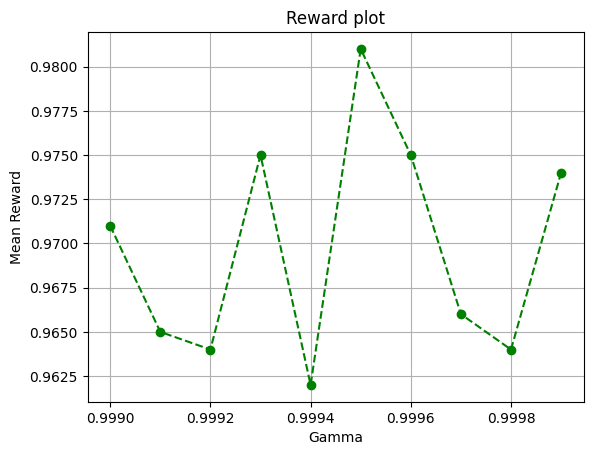

In [42]:
# Create plot
plt.plot(gammas, mean_rewards, color='green', marker='o', linestyle='--')
#plt.xticks(np.arange(0.999, 0.9999, 0.0001))
# Add title and labels
plt.title('Reward plot')
plt.xlabel('Gamma')
plt.ylabel('Mean Reward')

# Add grid
plt.grid(True)